In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [44]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False, prob=1.0,reg=0.0):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [loss_val,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now,
                         keep_prob: prob }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

# My Model

In [50]:
# Feel free to play with this cell

def my_model(X,y,is_training, keep_prob, reg):
    Wconv1 = tf.get_variable("Wconv1", shape=[5, 5, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])

    Wconv2 = tf.get_variable("Wconv2", shape=[5, 5, 32, 64])
    bconv2 = tf.get_variable("bconv2", shape=[64])

    Wconv3 = tf.get_variable("Wconv3", shape=[5, 5, 64, 64])
    bconv3 = tf.get_variable("bconv3", shape=[64])

    Wconv4 = tf.get_variable("Wconv4", shape=[5, 5, 32, 32])
    bconv4 = tf.get_variable("bconv4", shape=[32])

    Wconv5 = tf.get_variable("Wconv5", shape=[3, 3, 64, 64])
    bconv5 = tf.get_variable("bconv5", shape=[64])

    Wconv6 = tf.get_variable("Wconv6", shape=[3, 3, 64, 64])
    bconv6 = tf.get_variable("bconv6", shape=[64])

    W1 = tf.get_variable("W1", shape=[4*4*64,10])
    b1 = tf.get_variable("b1", shape=[10])
    
    reg = tf.contrib.layers.l2_regularizer(scale=reg)

    # CONV RELU CONV RELU MAX_POOLING
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1, 1, 1, 1], padding='SAME') + bconv1
    a1 = tf.contrib.layers.batch_norm(a1, center=True, scale=True, is_training=is_training)
    h1 = tf.nn.relu(a1)
    a1 = tf.nn.conv2d(h1, Wconv4, strides=[1,1,1,1], padding='SAME') + bconv4
    a1 = tf.contrib.layers.batch_norm(a1, center=True, scale=True, is_training=is_training)
    h1 = tf.nn.relu(a1)
    h1 = tf.nn.max_pool(h1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID') # 16x16x32
    h1 = tf.nn.dropout(h1, keep_prob) # Adding dropouts

    a1 = tf.nn.conv2d(h1, Wconv2, strides=[1,1,1,1], padding='SAME') + bconv2
    a1 = tf.contrib.layers.batch_norm(a1, center=True, scale=True, is_training=is_training)
    h1 = tf.nn.relu(a1)
    a1 = tf.nn.conv2d(h1, Wconv5, strides=[1,1,1,1], padding='SAME') + bconv5
    a1 = tf.contrib.layers.batch_norm(a1, center=True, scale=True, is_training=is_training)
    h1 = tf.nn.relu(a1)
    h1 = tf.nn.max_pool(h1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID') # 8x8x64
    h1 = tf.nn.dropout(h1, keep_prob) # Adding dropouts

    a1 = tf.nn.conv2d(h1, Wconv3, strides=[1,1,1,1], padding='SAME') + bconv3 
    a1 = tf.contrib.layers.batch_norm(a1, center=True, scale=True, is_training=is_training)
    h1 = tf.nn.relu(a1)
    a1 = tf.nn.conv2d(h1, Wconv6, strides=[1,1,1,1], padding='SAME') + bconv6 # 4 * 4 * 64
    a1 = tf.contrib.layers.batch_norm(a1, center=True, scale=True, is_training=is_training)
    h1 = tf.nn.relu(a1)
    h1 = tf.nn.max_pool(h1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID') # 4x4x64
    
    h1_flat = tf.reshape(h1,[-1,4*4*64])
    y_out = tf.matmul(h1_flat,W1) + b1
    
    return y_out

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
keep_prob = tf.placeholder(tf.float32)
reg = tf.placeholder(tf.float32)
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X,y,is_training, keep_prob,reg)

total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

optimizer = tf.train.RMSPropOptimizer(learning_rate=1e-3)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

# Run my_model

Training
Iteration 0: with minibatch training loss = 4.04 and accuracy of 0.16
Iteration 100: with minibatch training loss = 1.78 and accuracy of 0.33
Iteration 200: with minibatch training loss = 1.7 and accuracy of 0.41
Iteration 300: with minibatch training loss = 1.72 and accuracy of 0.34
Iteration 400: with minibatch training loss = 1.43 and accuracy of 0.5
Iteration 500: with minibatch training loss = 1.35 and accuracy of 0.56
Iteration 600: with minibatch training loss = 1.69 and accuracy of 0.45
Iteration 700: with minibatch training loss = 1.19 and accuracy of 0.55
Epoch 1, Overall loss = 1.54 and accuracy of 0.449


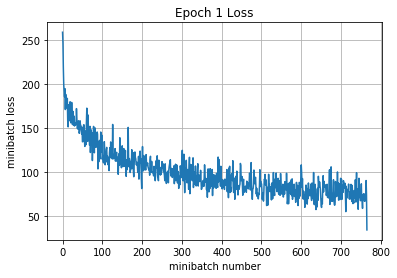

Iteration 800: with minibatch training loss = 1.03 and accuracy of 0.66
Iteration 900: with minibatch training loss = 1.06 and accuracy of 0.53
Iteration 1000: with minibatch training loss = 1.06 and accuracy of 0.58
Iteration 1100: with minibatch training loss = 1.06 and accuracy of 0.64
Iteration 1200: with minibatch training loss = 0.867 and accuracy of 0.69
Iteration 1300: with minibatch training loss = 0.946 and accuracy of 0.72
Iteration 1400: with minibatch training loss = 1.05 and accuracy of 0.62
Iteration 1500: with minibatch training loss = 0.902 and accuracy of 0.67
Epoch 2, Overall loss = 0.988 and accuracy of 0.647


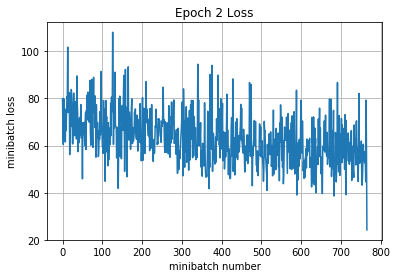

Iteration 1600: with minibatch training loss = 0.888 and accuracy of 0.75
Iteration 1700: with minibatch training loss = 0.825 and accuracy of 0.67
Iteration 1800: with minibatch training loss = 0.813 and accuracy of 0.69
Iteration 1900: with minibatch training loss = 0.547 and accuracy of 0.8
Iteration 2000: with minibatch training loss = 0.934 and accuracy of 0.66
Iteration 2100: with minibatch training loss = 0.684 and accuracy of 0.77
Iteration 2200: with minibatch training loss = 0.675 and accuracy of 0.8
Epoch 3, Overall loss = 0.812 and accuracy of 0.713


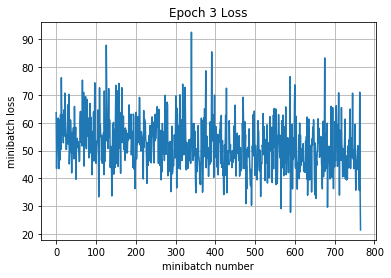

Iteration 2300: with minibatch training loss = 0.563 and accuracy of 0.8
Iteration 2400: with minibatch training loss = 0.809 and accuracy of 0.7
Iteration 2500: with minibatch training loss = 0.759 and accuracy of 0.78
Iteration 2600: with minibatch training loss = 0.848 and accuracy of 0.66
Iteration 2700: with minibatch training loss = 0.776 and accuracy of 0.73
Iteration 2800: with minibatch training loss = 0.7 and accuracy of 0.78
Iteration 2900: with minibatch training loss = 0.682 and accuracy of 0.77
Iteration 3000: with minibatch training loss = 0.634 and accuracy of 0.75
Epoch 4, Overall loss = 0.709 and accuracy of 0.753


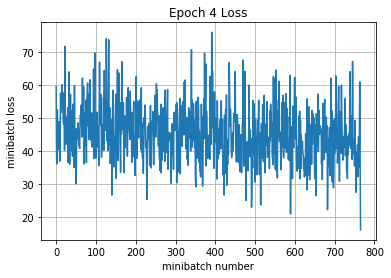

Iteration 3100: with minibatch training loss = 0.729 and accuracy of 0.69
Iteration 3200: with minibatch training loss = 0.493 and accuracy of 0.84
Iteration 3300: with minibatch training loss = 0.638 and accuracy of 0.8
Iteration 3400: with minibatch training loss = 0.539 and accuracy of 0.8
Iteration 3500: with minibatch training loss = 0.785 and accuracy of 0.75
Iteration 3600: with minibatch training loss = 0.437 and accuracy of 0.83
Iteration 3700: with minibatch training loss = 0.614 and accuracy of 0.81
Iteration 3800: with minibatch training loss = 0.709 and accuracy of 0.72
Epoch 5, Overall loss = 0.643 and accuracy of 0.776


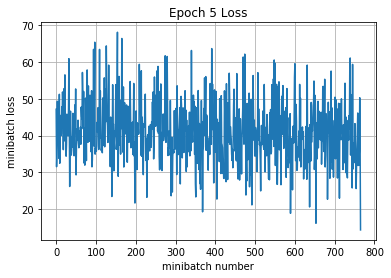

Iteration 3900: with minibatch training loss = 0.417 and accuracy of 0.88
Iteration 4000: with minibatch training loss = 0.592 and accuracy of 0.8
Iteration 4100: with minibatch training loss = 0.471 and accuracy of 0.83
Iteration 4200: with minibatch training loss = 0.522 and accuracy of 0.78
Iteration 4300: with minibatch training loss = 0.817 and accuracy of 0.67
Iteration 4400: with minibatch training loss = 0.774 and accuracy of 0.73
Iteration 4500: with minibatch training loss = 0.671 and accuracy of 0.77
Epoch 6, Overall loss = 0.587 and accuracy of 0.794


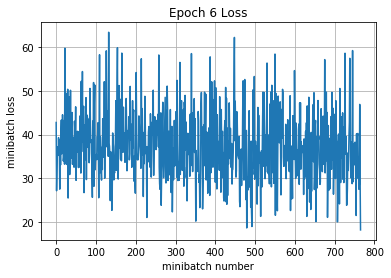

Iteration 4600: with minibatch training loss = 0.474 and accuracy of 0.84
Iteration 4700: with minibatch training loss = 0.512 and accuracy of 0.91
Iteration 4800: with minibatch training loss = 0.49 and accuracy of 0.78
Iteration 4900: with minibatch training loss = 0.711 and accuracy of 0.7
Iteration 5000: with minibatch training loss = 0.408 and accuracy of 0.88
Iteration 5100: with minibatch training loss = 0.481 and accuracy of 0.83
Iteration 5200: with minibatch training loss = 0.562 and accuracy of 0.83
Iteration 5300: with minibatch training loss = 0.738 and accuracy of 0.75
Epoch 7, Overall loss = 0.548 and accuracy of 0.812


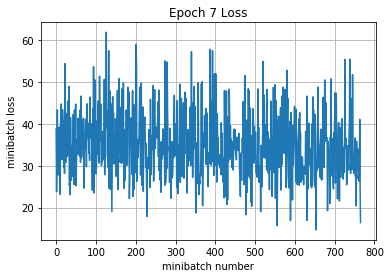

Iteration 5400: with minibatch training loss = 0.588 and accuracy of 0.8
Iteration 5500: with minibatch training loss = 0.464 and accuracy of 0.86
Iteration 5600: with minibatch training loss = 0.539 and accuracy of 0.83
Iteration 5700: with minibatch training loss = 0.425 and accuracy of 0.88
Iteration 5800: with minibatch training loss = 0.467 and accuracy of 0.86
Iteration 5900: with minibatch training loss = 0.506 and accuracy of 0.81
Iteration 6000: with minibatch training loss = 0.404 and accuracy of 0.86
Iteration 6100: with minibatch training loss = 0.933 and accuracy of 0.73
Epoch 8, Overall loss = 0.508 and accuracy of 0.823


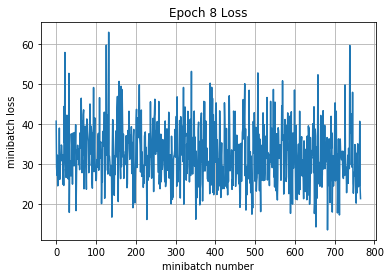

Iteration 6200: with minibatch training loss = 0.552 and accuracy of 0.84
Iteration 6300: with minibatch training loss = 0.54 and accuracy of 0.81
Iteration 6400: with minibatch training loss = 0.517 and accuracy of 0.8
Iteration 6500: with minibatch training loss = 0.482 and accuracy of 0.84
Iteration 6600: with minibatch training loss = 0.409 and accuracy of 0.8
Iteration 6700: with minibatch training loss = 0.431 and accuracy of 0.83
Iteration 6800: with minibatch training loss = 0.447 and accuracy of 0.83
Epoch 9, Overall loss = 0.48 and accuracy of 0.832


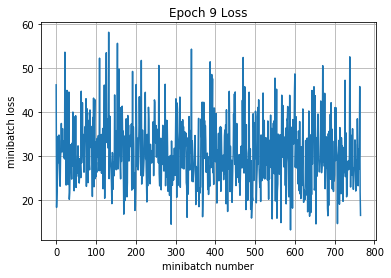

Iteration 6900: with minibatch training loss = 0.382 and accuracy of 0.88
Iteration 7000: with minibatch training loss = 0.484 and accuracy of 0.77
Iteration 7100: with minibatch training loss = 0.506 and accuracy of 0.84
Iteration 7200: with minibatch training loss = 0.347 and accuracy of 0.89
Iteration 7300: with minibatch training loss = 0.567 and accuracy of 0.78
Iteration 7400: with minibatch training loss = 0.399 and accuracy of 0.83
Iteration 7500: with minibatch training loss = 0.442 and accuracy of 0.81
Iteration 7600: with minibatch training loss = 0.402 and accuracy of 0.86
Epoch 10, Overall loss = 0.456 and accuracy of 0.839


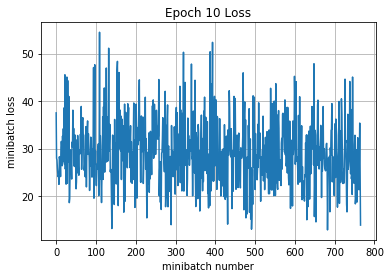

Validation
Epoch 1, Overall loss = 0.591 and accuracy of 0.804


(0.59095547962188721, 0.80400000000000005)

In [51]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True,0.6,0.01)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [52]:
### Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Epoch 1, Overall loss = 0.362 and accuracy of 0.874
Validation
Epoch 1, Overall loss = 0.591 and accuracy of 0.804


(0.59095549964904781, 0.80400000000000005)

In [53]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

sess.close()

Test
Epoch 1, Overall loss = 0.625 and accuracy of 0.8
